In part 3, we computed the linguistic divergence between two corpora consisting of texts from **r/MensRights** and **r/Feminism** respectively, and we had some idea about how the linguistic distance between the two subreddits has evolved over time -- especially, we noticed the high similarity between rMR and rFem during 2012 and 2013.

Note that in part 3 the corpus from **r/MensRights** or **r/Feminism** was represented as *bag of words* (e.g. `{"apple": 2, "pen": 3, "pineapple": 1, ...}`), which is essentially the same as unigram language model.

In this part we'll perform further analysis to quantitatively measure the linguistic distance between the two subreddits. 

1. First we'll train a bigram language model ([language_model.py](https://github.com/chao-ji/reddit/blob/master/language_model.py)) using the corpus from one subreddit (e.g. rMR), which will be used to compute the likelihood of posts within different time intervals from the other subreddit (e.g. rFem).
2. Then we'll extend the analysis at the *semantic level*: we'll make use of the vector representation (doc2vec model, see [Part6](https://github.com/chao-ji/reddit/blob/master/Part%206%20Polarization%20of%20rMR%20and%20rFem%20and%20User%20Profiling.ipynb)) of text and compute the linguistic distance based on vector arithmetics.

We'll use both approaches to compute the linguistic distance between rMR and rFem, and see how it has changed over time.

In [1]:
import datetime
import itertools
import pickle

import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.patches as patches

from language_model import *

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))
sw.update(stopwords.words("english"))

### 1. Bigram language model

First we need to create a generator for the text data. This is because the text data is too large to fit in memory, and we only need traverse the data in one pass to train or evaluate the the bigram model.

In [2]:
def men_corpus():
    for doc in db["MensRights"].find({}, {"created_utc": 1, "tokens": 1, "_id": 0}).sort("created_utc", pymongo.ASCENDING):
        tokens = doc["tokens"].split()
        if len(tokens) >= 30:
            yield tokens
            
def fem_corpus():
    for doc in db["Feminism"].find({}, {"created_utc": 1, "tokens": 1, "_id": 0}).sort("created_utc", pymongo.ASCENDING):
        tokens = doc["tokens"].split()
        if len(tokens) >= 30:
            yield tokens       

`men_corpus()` and `fem_corpus()` will yield a tokenized post (list of words). In the training stage, the collection of list of tokens will be used to train the bigram language model. Then in the test stage, a probability (log-transformed) will be computed for each tokenized post.

In [3]:
print next(men_corpus())

[u'i', u'have', u'a', u'few', u'thoughts', u'on', u'this', u'and', u'related', u'issues', u'.', u'banishment', u'used', u'to', u'be', u'considered', u'a', u'punishment', u'.', u'today', u',', u'social', u'banishment', u'is', u"n't", u'recognized', u'as', u'a', u'form', u'of', u'suffering', u'or', u'loss', u'for', u'the', u'victim', u'.', u'yet', u'banishment', u'from', u'a', u'job', u'means', u'more', u'than', u'loss', u'of', u'community', u'membership', u'-', u'it', u'means', u'loss', u'of', u'livelihood', u'.', u'this', u'man', u'was', u'banished', u'upon', u'the', u'authority', u'of', u'an', u'anonymous', u',', u'unsubstantiated', u'claim', u'.', u'slander', u'is', u'considered', u'criminal', u'or', u',', u'at', u'least', u',', u'carries', u'liability', u'within', u'certain', u'contexts', u'.', u'in', u'the', u'case', u'of', u'rape', u'accusation', u',', u'slander', u'is', u'not', u'considered', u'as', u'an', u'offense', u'to', u'the', u'victim', u"'s", u'good', u'name', u'.', u'so'

The probabilities computed in bigram model are smoothed using [Good-Turing](https://en.wikipedia.org/wiki/Good%E2%80%93Turing_frequency_estimation) method, for which we need to find the number of words in the testing corpus that do not show up in the training corpus (aka *out-of-vocabulary* words). 

Because we'll swtich the roles of two corpora (i.e. as training and test set), we'll compute the number of *out-of-vocabulary* words separately for **r/MensRights** and **r/Feminism**:

In [4]:
corpus_men_tokens = set()

for tokens in men_corpus():
        corpus_men_tokens.update(tokens)
        
corpus_fem_tokens = set()

for tokens in fem_corpus():
        corpus_fem_tokens.update(tokens)

# out-of-vocabulary for rMR: words in rFem that are not present in rMR
oov_men = len(corpus_fem_tokens - corpus_men_tokens)
# out-of-vocabulary for rFem: words in rMR that are not present in rFem
oov_fem = len(corpus_men_tokens - corpus_fem_tokens)

####  Training corpus: rMensRirhgts; Test corpus: rFeminism

First train bigram model using rMR corpus:

In [5]:
bigram_men = Bigram(special_token=False)
bigram_men = bigram_men.fit(men_corpus(), oov_men)

Define helper function that computes the avearge of the log-transformed probabilities of posts in subreddit `subreddit` and in date `d`:

In [6]:
def eval_sentprob(subreddit, model, d):
#    if d.month == 1 and d.day == 1:
#        print d
        
    docs = db[subreddit].find({"date": d}, {"date": 1, "tokens": 1, "_id": 0})
    test_corpus = map(lambda d: d["tokens"].split(), docs)
    test_corpus = filter(lambda x: len(x) >= 2, test_corpus)
    probs = np.array(map(lambda x: model.predict(x), test_corpus))
    probs = probs[~np.isnan(probs)]
    if len(probs) > 0:
        return np.mean(probs)
    else:
        return np.nan

For each date `d`, find the list of posts posted in date `d` and compute the average of their log-probabilities.

In [7]:
dates = map(lambda d: d["date"], db["Feminism"].find({}, {"date": 1, "_id": 0}))
dates = sorted(list(set(dates)))
test_probs = map(lambda x: eval_sentprob("Feminism", bigram_men, x), dates)

In [8]:
# Build series object with dates as the index
ser = pd.Series(test_probs, index=dates)
ser = ser[ser.notnull()]
ser[-10:]

2016-07-22   -5.248964
2016-07-23   -5.246979
2016-07-24   -5.376429
2016-07-25   -5.059125
2016-07-26   -5.593586
2016-07-27   -5.262577
2016-07-28   -4.918003
2016-07-29   -5.368105
2016-07-30   -5.113339
2016-07-31   -5.315875
dtype: float64

Plot the average of log-probabilities as a function of date:

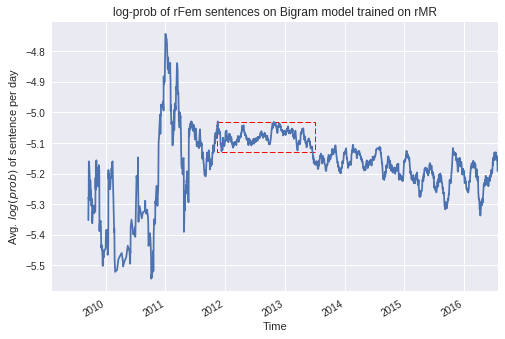

In [9]:
ser = ser.rolling(window=30).mean()
ser.plot()
plt.title("log-prob of rFem sentences on Bigram model trained on rMR")
plt.ylabel("Avg. $log(prob)$ of sentence per day")
plt.xlabel("Time")

ax = plt.gca()

rect = patches.Rectangle([734453., -5.03], 600., -0.1, linewidth=1, edgecolor='r',
                             facecolor='none', linestyle="--")
ax.add_patch(rect)

plt.show()

The language model was trained using the rMR corpus, and it was then used to evaluate posts from rFem corpus. So posts with greater probability (log-transformed) can be interpreted to have more similar linguistic pattern with respect to the rMR corpus. 

Note that there were not as many posts *per day* in the early stage (roughly before 2012) as in the rest of the timeline, so the averages were taken over samll samples and the observed vairance of the averaged log-probabilities may just be artifact. 

However, we do observed an interval for which the average log-probability was consistently greater than the rest of the timeline (red dashed box).

**Training corpus: rMensRirhgts; Test corpus: rFeminism**

Now repeat the process by switching the roles of rMR and rFem:

In [10]:
# Train bigram model using rMR corpus

bigram_fem = Bigram(special_token=False)
bigram_fem = bigram_fem.fit(fem_corpus(), oov_fem)

In [11]:
# For each date `d`, find the list of posts posted in date `d` 
# and compute the average of their log-probabilities.

dates = map(lambda d: d["date"], db["MensRights"].find({}, {"date": 1, "_id": 0}))
dates = sorted(list(set(dates)))
test_probs = map(lambda x: eval_sentprob("MensRights", bigram_fem, x), dates)

In [12]:
# Build series object with dates as the index

ser = pd.Series(test_probs, index=dates)
ser = ser[ser.notnull()]
ser[-10:]

2016-07-22   -5.478767
2016-07-23   -5.437814
2016-07-24   -5.487762
2016-07-25   -5.476423
2016-07-26   -5.449473
2016-07-27   -5.339723
2016-07-28   -5.351037
2016-07-29   -5.365997
2016-07-30   -5.505726
2016-07-31   -5.511511
dtype: float64

Plot the average of log-probabilities as a function of date:

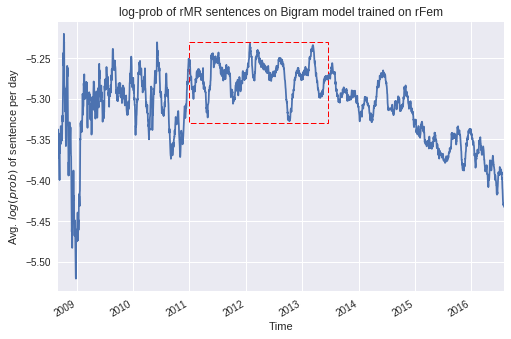

In [13]:
ser = ser.rolling(window=30).mean()
ser = ser[120:]
ser.plot()
plt.title("log-prob of rMR sentences on Bigram model trained on rFem")
plt.ylabel("Avg. $log(prob)$ of sentence per day")
plt.xlabel("Time")

ax = plt.gca()

rect = patches.Rectangle([734138., -5.23], 900., -0.1, linewidth=1, edgecolor='r',
                             facecolor='none', linestyle="--")
ax.add_patch(rect)

ax.get_xticks()
plt.show()

Note that we have a similar issue (i.e. limited sample size) in the earlier stage, and we also observed an interval with high probability (red dashed box)

### 2. Semantic distance using vector arithmetics 

The traditional statistical language models (e.g. bag-of-words, or n-gram) encode textual data (words or sentences) using *sparse* and *local* encoding (`"cat"=[0, 0, 1, 0, 0]`, `"kitten"=[1, 0, 0, 0, 0]`), so it is not able to capture the semantic similarity of distinct words ("cat" vs. "kitten").

In comparison, word2vec and doc2vec learns the *distributed* and *dense* representation of words based on the contextual similarity of different words. So semantically similar words would have spatially close vector representations (for example, `"cat"=[0.101, 0.2, 0.3, 0.4, 0.5]`, `"kitten"=[0.1, 0.199, 0.3, 0.4, 0.501]`). The vector representation is known to be more robust to noisy data and is preferred over the traditional bag-of-words approaches in evaluating semantic similarities.

We'll apply the doc2vec model on the rMR and rFem corpus, which turns each post into a high-dimensional real-valued vector, such that posts with similar semantic content would have spatially close vector representations.

First we'll group the posts from rMR or rFem by the date $d$, which leads to lists of sets:
$V_{m}(d) = \{v^{m}_{1}, v^{m}_{2}, \cdots \}$ and $V_{f}(d) = \{v^{f}_{1}, v^{f}_{2}, \cdots \}$, then we'll compute the average of cosine distance over all pairs: $\frac{1}{|V_{m}|\cdot|V_{f}|} \sum_{i, j} cos\_dist(v^{m}_{i}, v^{f}_{j})$, and plot the average as a function of $d$.


See [Part6](https://github.com/chao-ji/reddit/blob/master/Part%206%20Polarization%20of%20rMR%20and%20rFem%20and%20User%20Profiling.ipynb) for more detail on the doc2vec model.

First we need to load the pre-trained doc2vec model:

In [14]:
import warnings
warnings.simplefilter('ignore')
    
from gensim import models
model = models.Doc2Vec.load("doc2vec_dbow_d100_n5_w15_mc5_s1e_05_t6.model")

Retrieve posts from database, and save as pandas dataframes. Note that only a subset of posts were used to train the doc2vec model (and have a vector representation), so we need to filter for the posts for which there is a vector representation:

In [15]:
men_posts = pd.DataFrame(list(db["MensRights"].find({}, {"date": 1, "created_utc": 1,
                                                         "author": 1, "_id": 1}).sort("created_utc",
                                                                                      pymongo.ASCENDING)))

fem_posts = pd.DataFrame(list(db["Feminism"].find({}, {"date": 1, "created_utc": 1,
                                                       "author": 1, "_id": 1}).sort("created_utc",
                                                                                    pymongo.ASCENDING)))

men_posts = men_posts[men_posts["_id"].map(lambda x: str(x) in model.docvecs)]
fem_posts = fem_posts[fem_posts["_id"].map(lambda x: str(x) in model.docvecs)]

In [16]:
men_posts[:10]

,_id,author,created_utc,date
0,57c657db79a3030ce0379124,kanuk876,2008-03-21 15:35:09,2008-03-21
1,57c657dc79a3030ce0380a72,WorcesterM,2008-03-24 09:05:47,2008-03-24
2,57c657dc79a3030ce0385021,WorcesterM,2008-03-25 11:54:29,2008-03-25
3,57c657dc79a3030ce03855c1,linuxlass,2008-03-25 13:27:03,2008-03-25
4,57c657dd79a3030ce0388c35,Xiphorian,2008-03-26 09:41:00,2008-03-26
11,57c657e579a3030ce03cc184,andymikey,2008-04-13 15:53:04,2008-04-13
13,57c657e979a3030ce03eb88d,Xiphorian,2008-04-21 23:41:30,2008-04-21
15,57c657ea79a3030ce03ee833,Xiphorian,2008-04-22 16:31:14,2008-04-22
16,57c657ea79a3030ce03f3b1d,yojustkeepitreal,2008-04-23 19:27:39,2008-04-23
18,57c657ee79a3030ce040b25c,linuxlass,2008-04-29 17:18:57,2008-04-29


In [17]:
fem_posts[:10]

,_id,author,created_utc,date
4,57c655e779a3030ce04be7d5,cyborg_selkie,2009-05-12 23:39:24,2009-05-12
7,57c6562979a3030ce06b6c95,Cassio,2009-07-02 19:02:15,2009-07-02
8,57c6563479a3030ce0701e1f,AnnArchist,2009-07-09 17:27:42,2009-07-09
9,57c6563579a3030ce0705285,Kowai03,2009-07-09 23:01:30,2009-07-09
11,57c6563679a3030ce0713754,nuuur32,2009-07-11 02:47:08,2009-07-11
14,57c6565f79a3030ce0857526,Cassio,2009-08-07 06:55:32,2009-08-07
15,57c6566579a3030ce0882abf,SwampGass,2009-08-10 18:19:39,2009-08-10
16,57c6566579a3030ce0882c6a,SwampGass,2009-08-10 18:27:49,2009-08-10
17,57c6566679a3030ce088ea23,Aerik,2009-08-11 15:11:40,2009-08-11
24,57c6568179a3030ce0948ad9,Naughtymonkey,2009-08-24 18:43:46,2009-08-24


Group the posts by date, and then group the subgroup by author ID:

In [18]:
men_by_date = men_posts.groupby("date").apply(lambda df: df.groupby("author").apply(lambda x: list(x["_id"])).to_dict())
fem_by_date = fem_posts.groupby("date").apply(lambda df: df.groupby("author").apply(lambda x: list(x["_id"])).to_dict())

In [19]:
men_by_date[-3:]

date
2016-07-29    {u'ExpendableOne': [57c0689079a3030c544c8333],...
2016-07-30    {u'JFSwifty': [57c068dd79a3030c546d9965], u'st...
2016-07-31    {u'EvrythingISayIsRight': [57c0691679a3030c548...
dtype: object

In [20]:
fem_by_date[-3:]

date
2016-07-29    {u'cupcakemichiyo': [57c0688179a3030c54460b9d]...
2016-07-30    {u'lumberanemone': [57c0690479a3030c547ed9ca],...
2016-07-31    {u'ebs152': [57c0693e79a3030c5497c60b], u'RSSa...
dtype: object

In [21]:
# Helper function that computes the average of cosine distance for each date `date`

def semantic_dist_between(date):
    if date.month == 1 and date.day == 1:
        print date

    radius = 15
    dates = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    l1 = [list(itertools.chain(*men_by_date[d].values()) ) for d in dates if d in men_by_date]
    l2 = [list(itertools.chain(*fem_by_date[d].values()) ) for d in dates if d in fem_by_date]
    l1 = list(itertools.chain(*l1))
    l2 = list(itertools.chain(*l2))
    
    X1 = np.array([model.docvecs[str(one_id)] for one_id in l1])
    X2 = np.array([model.docvecs[str(one_id)] for one_id in l2])
    
    return cosine_distances(X1, X2).mean()

Apply `semantic_dist_between` on the lits of datss

In [22]:
dates = sorted(list(set(men_posts["date"]) & set(fem_posts["date"])))
arr = map(lambda d: semantic_dist_between(d), dates)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


[ 733773.  734138.  734503.  734869.  735234.  735599.  735964.]


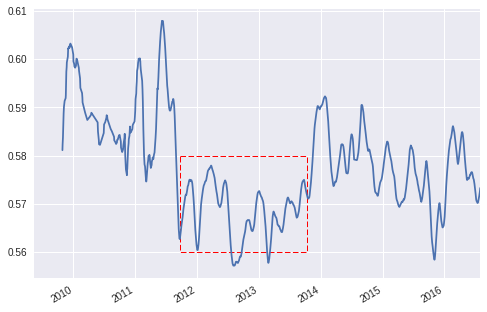

In [23]:
s = pd.Series(arr, index=dates)
s = pd.rolling_mean(s, window=30)
s.plot()

ax = plt.gca()

rect = patches.Rectangle([734400., 0.58], 750., -0.02, linewidth=1, edgecolor='r',
                             facecolor='none', linestyle="--")
ax.add_patch(rect)

print ax.get_xticks()

plt.show()

Taking the results in this part and part 1, 3 together, we can see that rMR and rFem were more similar during 2012-2013 than elsewhere in the timeline, and this happens to coincide with the period with the elevated cross-posting activity between the rMR and rFem. 